In [8]:
import sys
print(sys.executable)
!{sys.executable} -m pip install transformers
!{sys.executable} -m pip install timm

c:\Users\zln92\AppData\Local\Programs\Python\Python310\python.exe
     ---------------------------------------- 9.0/9.0 MB 9.0 MB/s eta 0:00:00
     -------------------------------------- 287.4/287.4 kB 8.9 MB/s eta 0:00:00
     -------------------------------------- 145.3/145.3 kB 4.4 MB/s eta 0:00:00
     -------------------------------------- 269.0/269.0 kB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ------------------------------------- 401.2/401.2 kB 12.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 2.2/2.2 MB 8.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Define the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)

# Split the train_dataset into train and validation sets if needed
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example usage
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


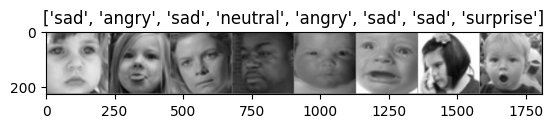

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Function to display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Display some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid from batch
img_grid = make_grid(images[:8])  # Display first 8 images

# Get class names
class_names = train_dataset.dataset.classes

# Show images
imshow(img_grid, title=[class_names[x] for x in labels[:8]])

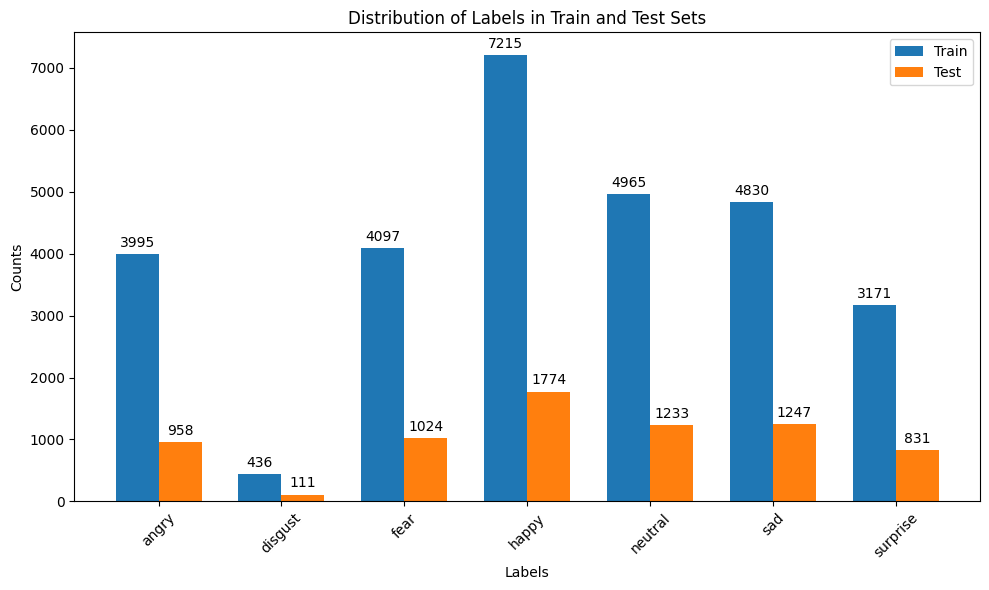

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images per class in the train and test sets
train_counter = Counter(train_dataset.dataset.targets)
test_counter = Counter(test_dataset.targets)

# Get the class names
class_names = train_dataset.dataset.classes

# Prepare the data for plotting
train_counts = [train_counter[i] for i in range(len(class_names))]
test_counts = [test_counter[i] for i in range(len(class_names))]

# Set the positions and width for the bars
bar_width = 0.35
index = np.arange(len(class_names))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, train_counts, bar_width, label='Train')
bar2 = ax.bar(index + bar_width, test_counts, bar_width, label='Test')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Distribution of Labels in Train and Test Sets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

# Add counts on top of the bars
def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_counts(bar1)
add_counts(bar2)

plt.tight_layout()
plt.show()

In [10]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=7, ignore_mismatched_sizes=True)
model = model.to('cuda')

optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, 'cuda')
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, 'cuda')
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


KeyboardInterrupt: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0a047d2a-49ae-49e7-9442-011956428446' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>